![](encabezado.png)


---

# Tomografía de Resistividad Eléctrica (TRE)
---

In [49]:
import numpy as np
import matplotlib.pyplot as plt

import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

# Crear el modelo de capas y la anomalía

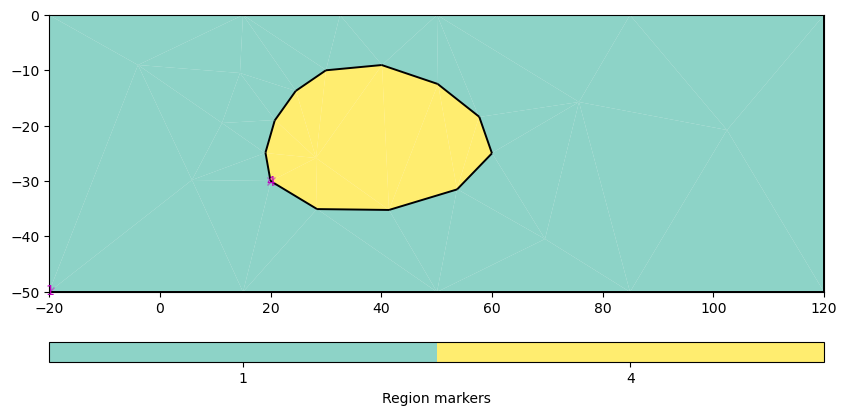

In [50]:
world = mt.createWorld(start=[-20,0], 
					   end=[120,-50], 
					#    layers=[-2,-30], 
					   worldMarker=True)
anom1 = mt.createPolygon(verts=[[20,-30],[60,-25],[30,-10]], interpolate='spline', isClosed=True, addNodes=3, marker=4)
# anom1 = mt.createRectangle(start=[20,-25], end=[40,-10], marker=4)
# anom = mt.createRectangle(start=[40,-5], end=[60,-20], marker=2)
# anom = mt.createPolygon(verts=[[70,-20],[80,-25],[90,-10]], interpolate='spline', isClosed=True, addNodes=5, marker=5)
# anom = mt.createCircle(pos=[-20,40], radius=8)

geom = world + anom1
pg.show(geom)
plt.gcf().set_size_inches(10,7)


# Generar electrodos

En el ejemplo se menciona el uso de un arreglo DD, ¿cómo se sabe qué tipo de arreglo es?

Debido a la experiencia, es conveniente agregar más nodos de refinamiento a una distancia vertical del 10% del espaciado de los electrodos para lograr suficiente precisión numérica, es decir, en (x,-0.1).

In [51]:
scheme = ert.createData(elecs=np.linspace(-20,120,48), schemeName='slm')
for p in scheme.sensors():
	geom.createNode(p)
	geom.createNode(p - [0,0.1])

# Generar malla

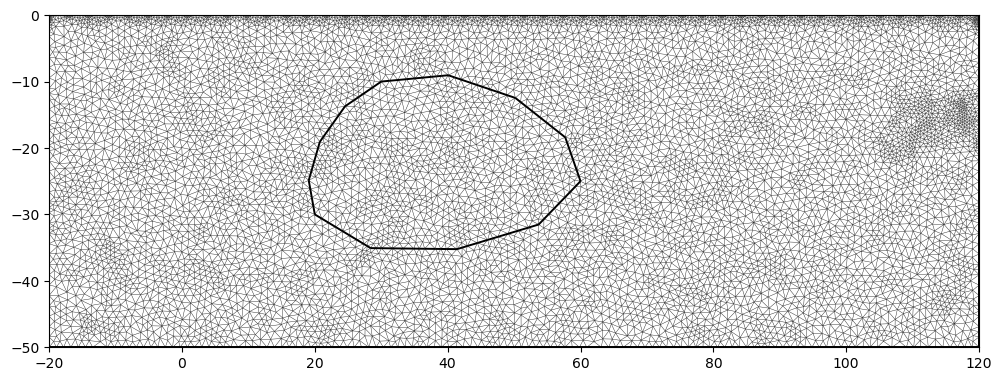

In [52]:
mesh = mt.createMesh(geom, quality=34, area=1)
%matplotlib inline
pg.show(mesh)
plt.gcf().set_size_inches(12,9)

# Mapeo de resistividades

17/01/24 - 12:49:36 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 2 within mesh.


17/01/24 - 12:49:36 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
17/01/24 - 12:49:36 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 5 within mesh.


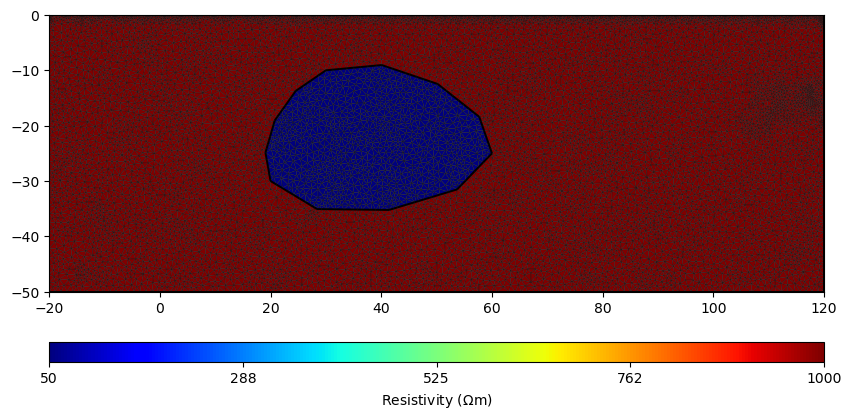

In [53]:
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1,1000.],
		  [2,200.],
		  [3,500.],
		  [4,50.],
		  [5,1000.]]
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True, cMap='jet')
plt.gcf().set_size_inches(10,7)


# Crear la simulación de $\rho_{a}$

In [54]:
data = ert.simulate(mesh=mesh, scheme=scheme, res=rhomap, noiseLevel=1, noiseAbs=1E-6, seed=1337)

pg.info(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

17/01/24 - 12:49:39 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 2 within mesh.
17/01/24 - 12:49:39 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
17/01/24 - 12:49:39 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 5 within mesh.
17/01/24 - 12:49:42 - pyGIMLi - INFO - Data error estimate (min:max)  0.010000018715109492 : 0.010011840506935042


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100


17/01/24 - 12:49:42 - pyGIMLi - INFO - 0.23003880833739157 18521.09572947891
17/01/24 - 12:49:42 - pyGIMLi - INFO - Simulated data Data: Sensors: 48 data: 529, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
17/01/24 - 12:49:42 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
17/01/24 - 12:49:42 - pyGIMLi - INFO - Simulated rhoa (min/max) 334.5037563987675 1015.9467816748376
17/01/24 - 12:49:42 - pyGIMLi - INFO - Selected data noise %(min/max) 1.000001871510949 1.0011840506935041


17/01/24 - 12:49:42 - pyGIMLi - INFO - Filtered rhoa (min/max) 334.5037563987675 1015.9467816748376


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1470ac3ac70>)

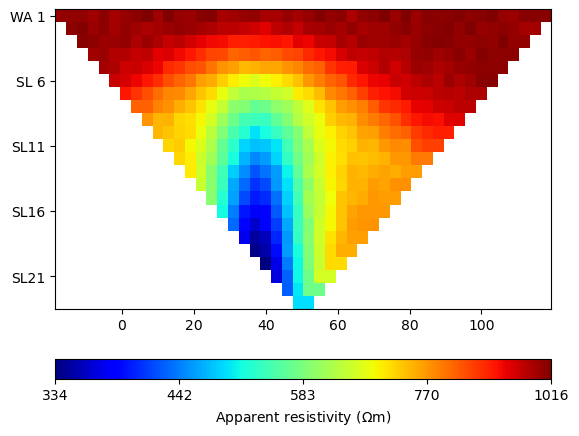

In [55]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

pg.show(data, cMap='jet')

# Inversión de $\rho_a$

In [56]:
mgr = ert.ERTManager(data)
inv = mgr.invert(lam=20, verbose=True)

17/01/24 - 12:49:44 - pyGIMLi - INFO - Found 2 regions.
17/01/24 - 12:49:44 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/01/24 - 12:49:44 - pyGIMLi - INFO - Found 2 regions.
17/01/24 - 12:49:44 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
17/01/24 - 12:49:44 - pyGIMLi - INFO - Creating forward mesh from region infos.
17/01/24 - 12:49:44 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
17/01/24 - 12:49:44 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2039 Cells: 3816 Boundaries: 2992
17/01/24 - 12:49:44 - pyGIMLi - INFO - Use median(data values)=793.0625572464692
17/01/24 - 12:49:44 - pyGIMLi - INFO - Created startmodel from forward operator: 762, min/max=793.062557/793.062557
17/01/24 - 12:49:44 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001471FED5860>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001471FED5EA0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001471FED5590>
min/max (data): 334/1016
min/max (error): 1%/1%
min/max (start model): 793/793
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  765.80
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =   31.19 (dPhi = 95.76%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 2 ... chi² =    8.46 (dPhi = 71.86%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² =    4.40 (dPhi = 43.39%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² =    1.01 (dPhi = 61.56%) lam: 20.0
-------------------

## Profundidad de investigación:

$$
F_{ID}(z) = \frac{2}{\pi}\cdot \frac{z}{\left( a^2 + 4z^2 \right)^{1.5}}
$$

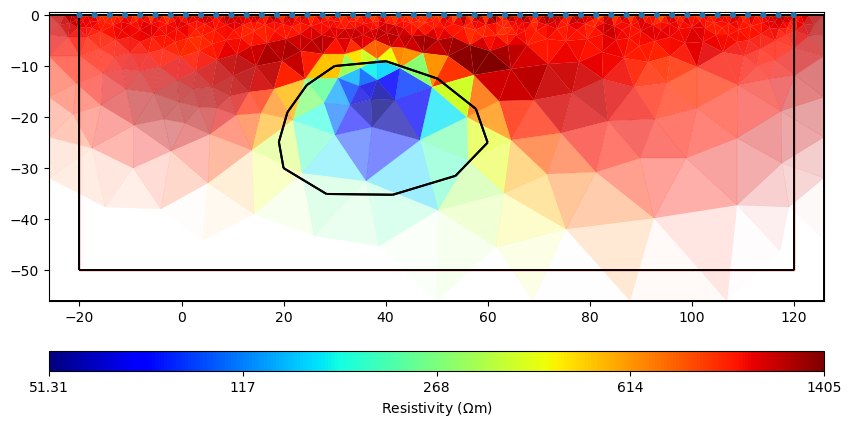

In [62]:
ax, cb = mgr.showResult(cMap='jet')
pg.show(geom, fillRegion=False, regionMarker=False, ax=ax)
plt.gcf().set_size_inches(10,7)

plt.show()

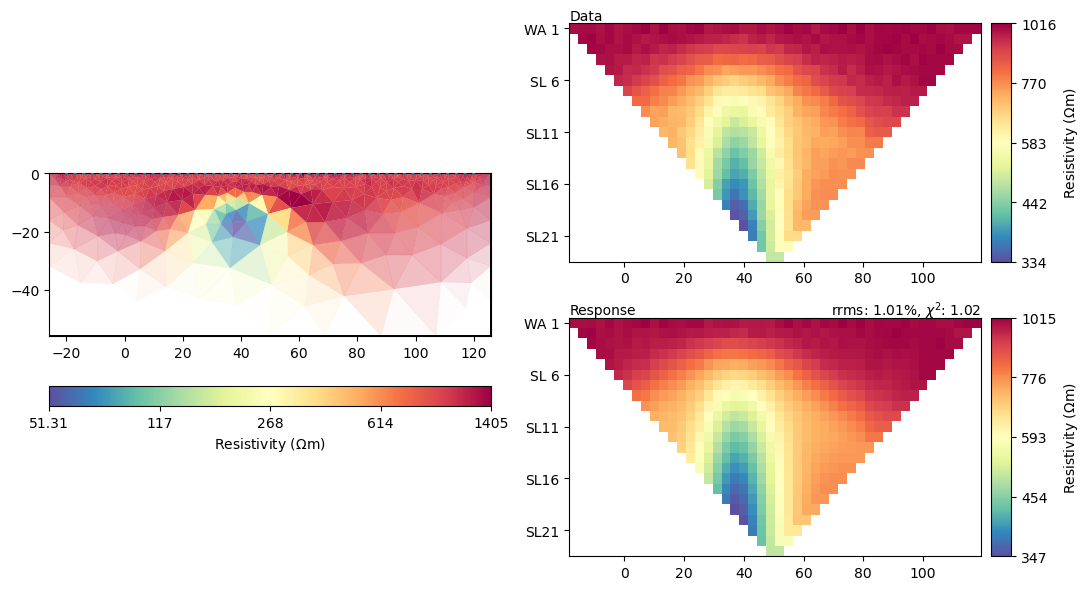

In [58]:
mgr.showResultAndFit()
plt.show()